In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sn

In [12]:
csv_file = "resources/model2.csv"
df_balanced = pd.read_csv(csv_file)
df_balanced.head()

,text,reaction,encoded_reaction
0,I don't understand that kids have to take a sw...,satisfied considerable comment,0
1,"The newest vessel in St. Elmo's fleet, they ha...",satisfied considerable comment,0
2,My husband and I were married on October 12th ...,satisfied considerable comment,0
3,I try to mention this tour company to every vi...,satisfied considerable comment,0
4,In our quest to find the best Indian luncheon ...,satisfied considerable comment,0


In [3]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['text'], df_balanced['encoded_reaction'], stratify=df_balanced['encoded_reaction'])
y_train.head(5)

26119    3
19301    1
19113    1
16446    1
11163    2
Name: encoded_reaction, dtype: int64

In [4]:
# Importing BERT
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [5]:
# BERT function
def embedding_generator(review):
    preprocessed_review = bert_preprocess(review)
    return bert_encoder(preprocessed_review)['pooled_output']

In [8]:
# Constructing layers
# Input Layer
review_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="input")
bert_out = embedding_generator(review_input)

# Neural Network Layers
num_classes = 4
layer = tf.keras.layers.Dropout(0.1, name='dropout')(bert_out)
layer = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(layer)

# Final Model
model = tf.keras.Model(inputs=[review_input], outputs=[layer])

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input[0][0]']                  
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [14]:
METRICS = [
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=METRICS)

In [15]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
722/722 [==============================] - 459s 630ms/step - loss: 1.3117 - accuracy: 0.3626
Epoch 2/5
722/722 [==============================] - 455s 630ms/step - loss: 1.2167 - accuracy: 0.4031
Epoch 3/5
722/722 [==============================] - 455s 630ms/step - loss: 1.1916 - accuracy: 0.4191
Epoch 4/5
722/722 [==============================] - 457s 633ms/step - loss: 1.1661 - accuracy: 0.4311
Epoch 5/5
722/722 [==============================] - 460s 637ms/step - loss: 1.1563 - accuracy: 0.4333


In [16]:
model.evaluate(X_test, y_test)

241/241 [==============================] - 154s 630ms/step - loss: 1.1518 - accuracy: 0.4344


[1.1518110036849976, 0.4344209134578705]

241/241 [==============================] - 150s 623ms/step


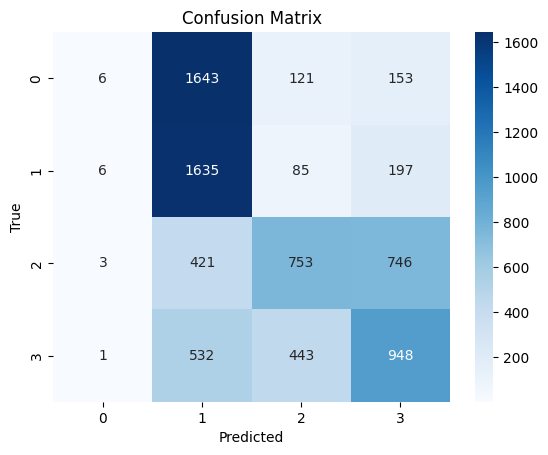

In [20]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualizing Confusion Matrix
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Classification Report
classification_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.00      0.01      1923
           1       0.39      0.85      0.53      1923
           2       0.54      0.39      0.45      1923
           3       0.46      0.49      0.48      1924

    accuracy                           0.43      7693
   macro avg       0.44      0.43      0.37      7693
weighted avg       0.44      0.43      0.37      7693

